Para poder disponer de una línea base vamos a uilizar el modelo Arisa para predecir, y en base a lo conseguido podemos dictaminar que es lo mínimo que podemos conseguir.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pickle
from statsmodels.tsa.arima_model import ARIMA

In [3]:



with open('/content/gdrive/MyDrive/PatronesComportamiento/trainingX.pkl', 'rb') as file:
        X_train=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/trainingy.pkl', 'rb') as file:
        y_train=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/testX.pkl', 'rb') as file:
        X_test=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/testy.pkl', 'rb') as file:
        y_test=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/validateX.pkl', 'rb') as file:
        X_val=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/validatey.pkl', 'rb') as file:
        y_val=pickle.load(file)


with open('/content/gdrive/MyDrive/PatronesComportamiento/mySeriesInten.pkl', 'rb') as file:
        mySeries=pickle.load(file)


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


----                              ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  286
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -317.103
Method:                       css-mle   S.D. of innovations              0.733
Date:                Thu, 02 Mar 2023   AIC                            644.206
Time:                        15:42:07   BIC                            662.486
Sample:                             1   HQIC                           651.534
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0177      0.114     -0.156      0.876      -0.240       0.205
ar.L1.D.y      0.9372      0.037     25.252      0.000       0.864       1.010
ma.L1.D.y     -0.9615      0.071    -13.450    

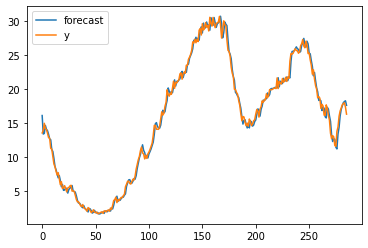

In [4]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

arima_model= ARIMA(mySeries[7],order=(1,1,2))
model=arima_model.fit()
model.plot_predict(dynamic=False)


print("----",model.summary())

267    17.917270
268    17.514930
269    16.122740
270    14.152420
271    13.357400
272    11.690300
273    12.351450
274    11.629210
275    10.224640
276     9.449438
277     9.151625
278     9.895131
279     9.775362
280     8.996255
281     9.123636
282     8.789474
283     8.862319
284     7.625468
285     7.978182
286     7.488722
dtype: float64
Int64Index([267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279,
            280, 281, 282, 283, 284, 285, 286],
           dtype='int64')


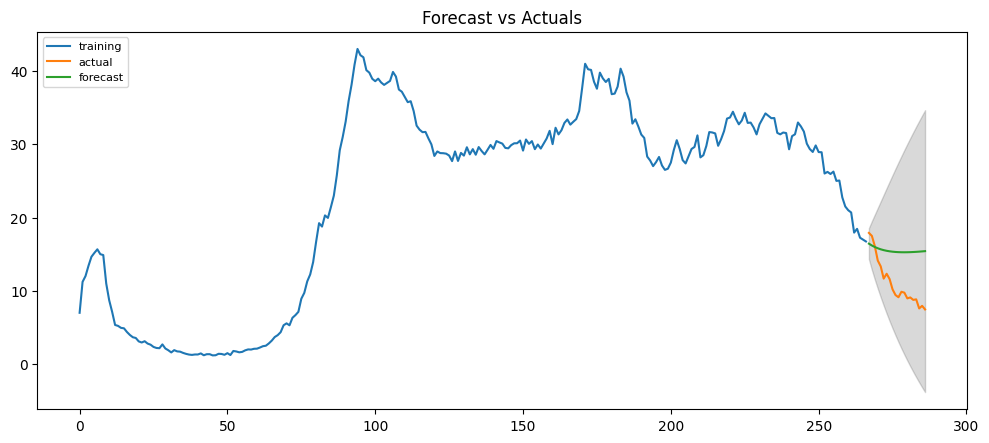

In [ ]:
from statsmodels.tsa.stattools import acf
import pandas as pd
import matplotlib.pyplot as plt


my_index =[i for i in range(287)]

n=9

# Create Training and Test
train = mySeries[n][:267]
test = mySeries[n][267:]

train = pd.Series(train, index=my_index[:267])
test = pd.Series(test, index=my_index[267:])

model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
fc, se, conf = fitted.forecast(20, alpha=0.05)  # 95% conf
print(test)
print(test.index)

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
